In [55]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from utils.preprocessing import clean_tweet_for_vader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# BERT data SHAP

In [56]:
# ========================================
# 1) Wczytanie danych
# ========================================

df = pd.read_csv("../data/bert_sentiment.csv") 
df["bert_clean2"] = df["bert_clean"].apply(clean_tweet_for_vader)
# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(
    df["bert_clean2"],
    df["bert_sentiment_label"],
    test_size=0.2,
    random_state=42
)

/Users/maciek_gangus/PycharmProjects/sentiment-analysis-shap/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train Accuracy: 0.8511576944148093
Test Accuracy: 0.7909122361895975

Confusion Matrix - Train:
 [[ 8986   543   742]
 [ 1210  5138  1322]
 [  577   768 15395]]

Confusion Matrix - Test:
 [[2061  274  214]
 [ 370 1141  454]
 [ 200  301 3656]]

Classification Report - Train:
               precision    recall  f1-score   support

    negative       0.83      0.87      0.85     10271
     neutral       0.80      0.67      0.73      7670
    positive       0.88      0.92      0.90     16740

    accuracy                           0.85     34681
   macro avg       0.84      0.82      0.83     34681
weighted avg       0.85      0.85      0.85     34681

Classification Report - Test:
               precision    recall  f1-score   support

    negative       0.78      0.81      0.80      2549
     neutral       0.66      0.58      0.62      1965
    positive       0.85      0.88      0.86      4157

    accuracy                           0.79      8671
   macro avg       0.76      0.76      0

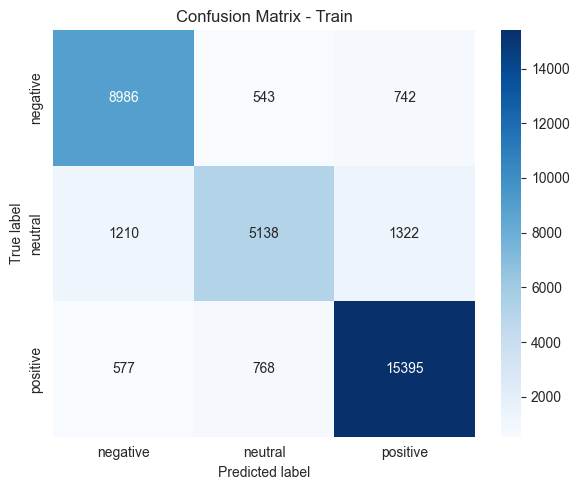

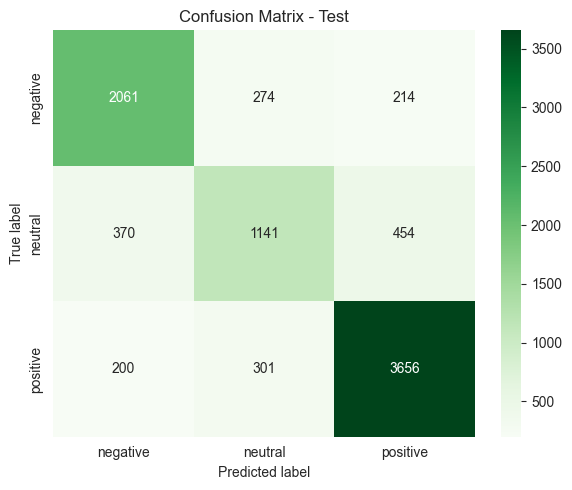

In [57]:
# ========================================
# 2) Pipeline: TF-IDF + LogisticRegression 
# ========================================

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'))
])

pipeline.fit(X_train, y_train)



y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nConfusion Matrix - Train:\n", confusion_matrix(y_train, y_pred_train))
print("\nConfusion Matrix - Test:\n", confusion_matrix(y_test, y_pred_test))

print("\nClassification Report - Train:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report - Test:\n", classification_report(y_test, y_pred_test))

print("\nLabel Distribution - Train:")
print(y_train.value_counts())
print("\nLabel Distribution - Test:")
print(y_test.value_counts())

class_names = pipeline.named_steps['clf'].classes_


cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [58]:
# ========================================
# 3) SHAP - LinearExplainer
# ========================================

X_train_tfidf = pipeline.named_steps['tfidf'].transform(X_train).toarray()
X_test_tfidf = pipeline.named_steps['tfidf'].transform(X_test).toarray()

explainer = shap.LinearExplainer(
    pipeline.named_steps['clf'],
    X_train_tfidf
)

shap_values = explainer(X_test_tfidf)

print("SHAP shape:", shap_values.values.shape)

SHAP shape: (8671, 5000, 3)


===== Klasa: negative =====


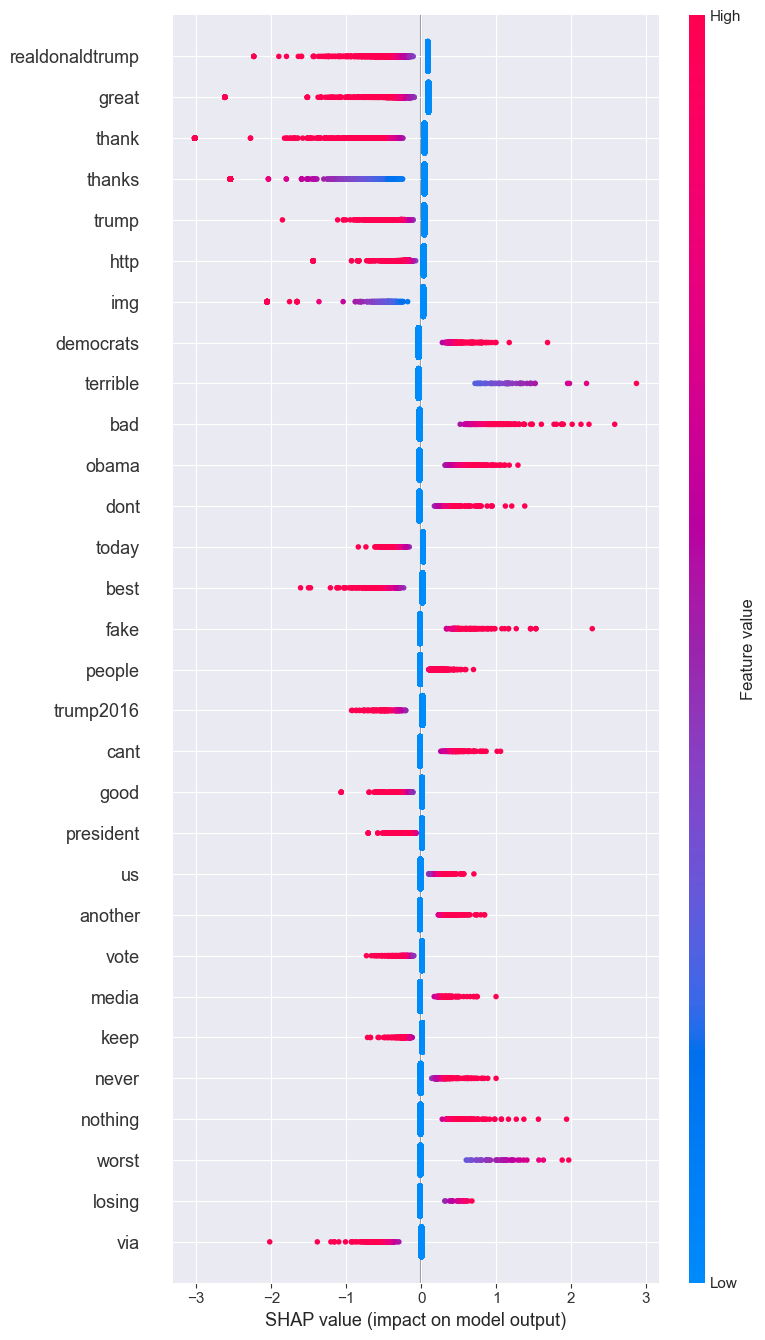

===== Klasa: neutral =====


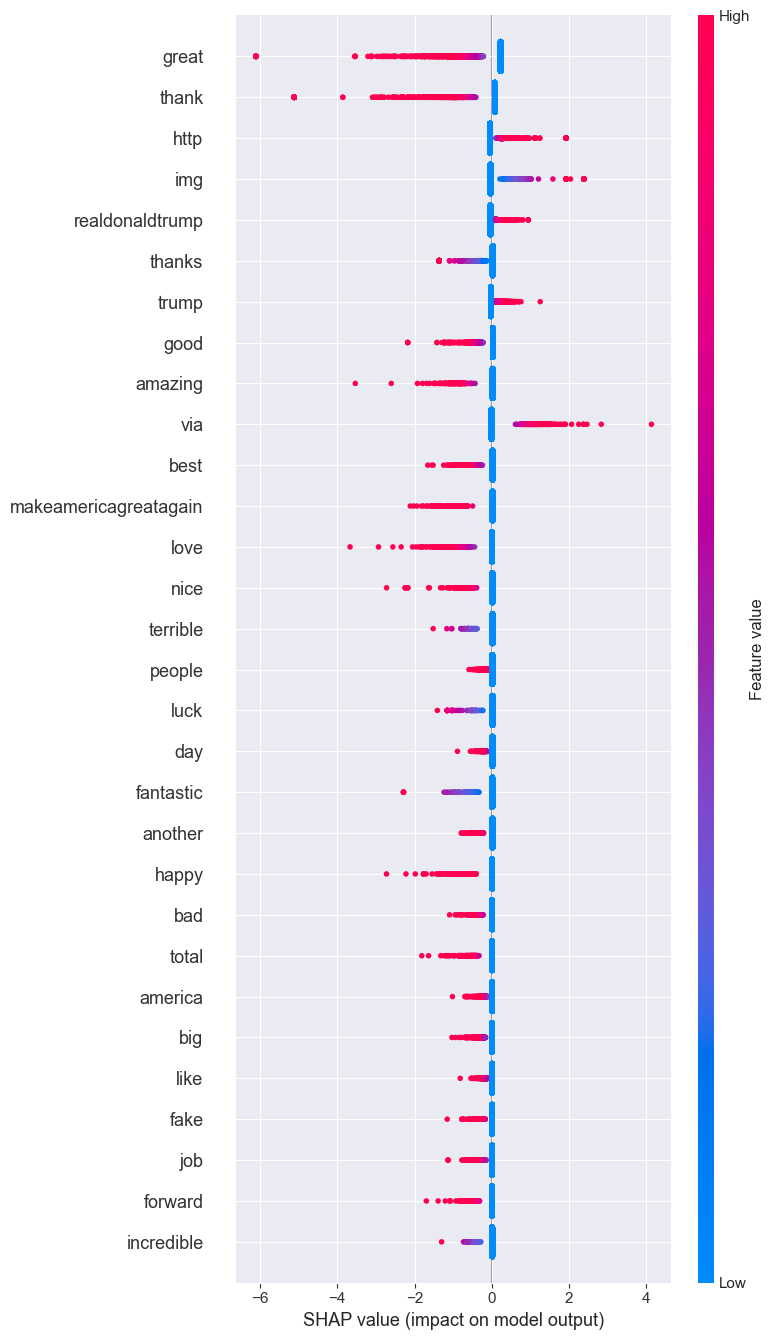

===== Klasa: positive =====


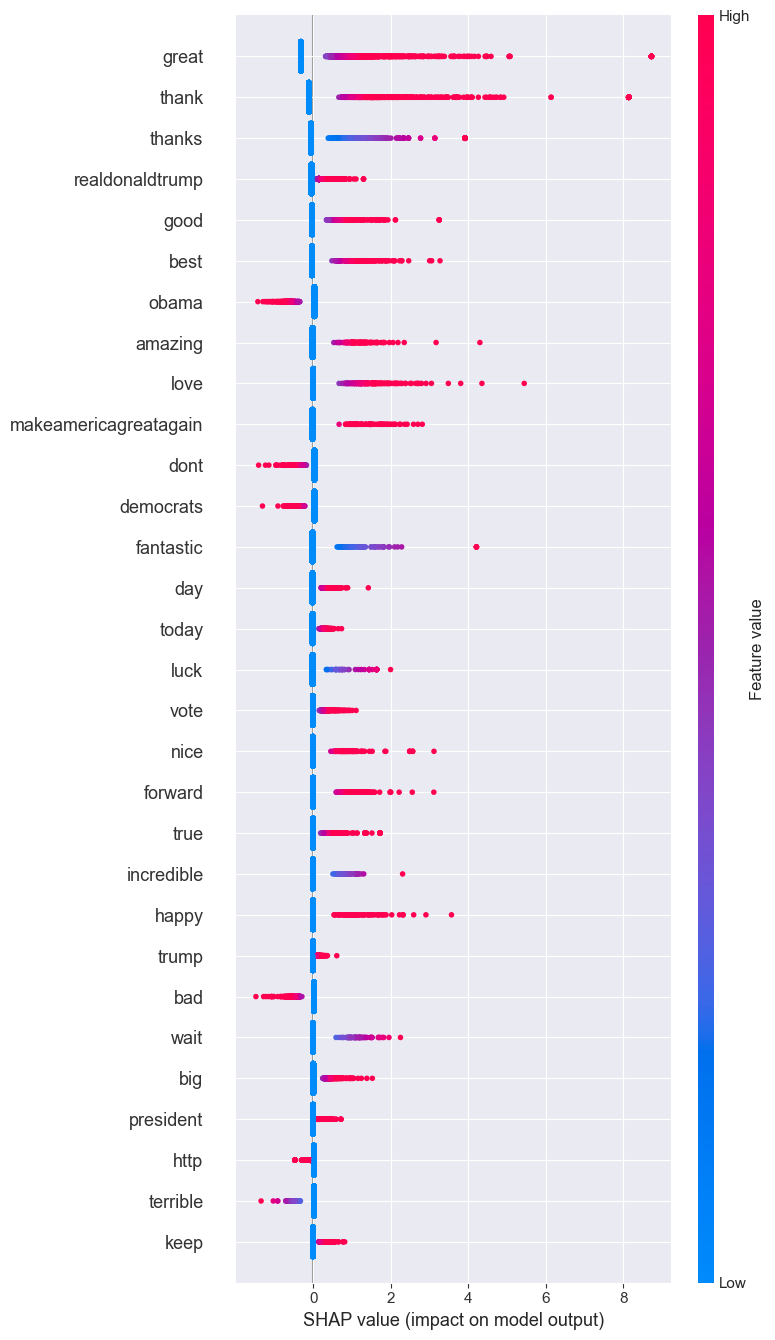

In [59]:
# ========================================
# 4) Beeswarm plot (summary_plot) - Z KOLORAMI
# ========================================

feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
class_names = pipeline.named_steps['clf'].classes_

X_test_df = pd.DataFrame(X_test_tfidf, columns=feature_names)

for i, class_name in enumerate(class_names):
    print(f"===== Klasa: {class_name} =====")
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test_df,
        feature_names=feature_names,
        plot_type='dot',
        show=True,
        max_display=30
    )
    

# VADER data SHAP

In [60]:
df = pd.read_csv("../data/vader_sentiment.csv") 

df = df.dropna(subset=["vader_clean", "vader_sentiment_label"])

X_train, X_test, y_train, y_test = train_test_split(
    df["vader_clean"],
    df["vader_sentiment_label"],
    test_size=0.2,
    random_state=42
)

/Users/maciek_gangus/PycharmProjects/sentiment-analysis-shap/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train Accuracy: 0.9139604761354444
Test Accuracy: 0.8569282329827805

Confusion Matrix - Train:
 [[ 7017   313   944]
 [  339  5262   520]
 [  595   267 19355]]

Confusion Matrix - Test:
 [[1655  148  341]
 [ 161 1096  246]
 [ 212  130 4664]]

Classification Report - Train:
               precision    recall  f1-score   support

    negative       0.88      0.85      0.86      8274
     neutral       0.90      0.86      0.88      6121
    positive       0.93      0.96      0.94     20217

    accuracy                           0.91     34612
   macro avg       0.90      0.89      0.90     34612
weighted avg       0.91      0.91      0.91     34612

Classification Report - Test:
               precision    recall  f1-score   support

    negative       0.82      0.77      0.79      2144
     neutral       0.80      0.73      0.76      1503
    positive       0.89      0.93      0.91      5006

    accuracy                           0.86      8653
   macro avg       0.83      0.81      0

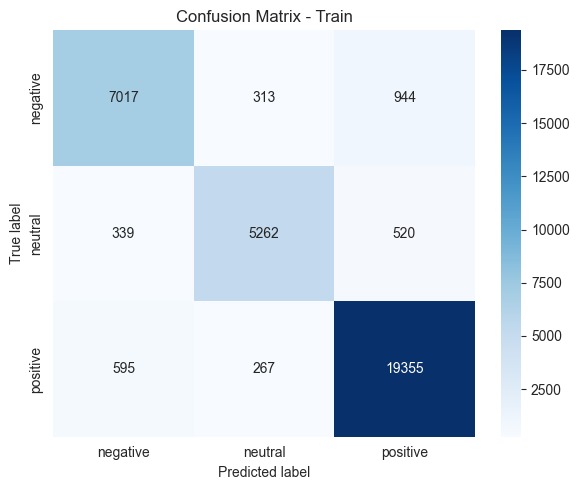

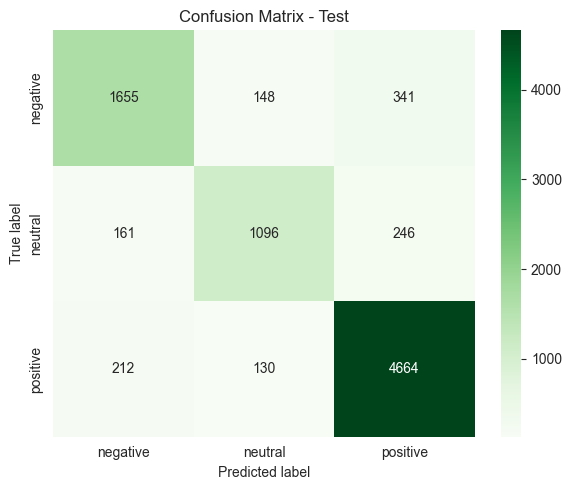

In [61]:
# ========================================
# 2) Pipeline: TF-IDF + LogisticRegression (multi-class)
# ========================================

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'))
])

pipeline.fit(X_train, y_train)


y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nConfusion Matrix - Train:\n", confusion_matrix(y_train, y_pred_train))
print("\nConfusion Matrix - Test:\n", confusion_matrix(y_test, y_pred_test))

print("\nClassification Report - Train:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report - Test:\n", classification_report(y_test, y_pred_test))

print("\nLabel Distribution - Train:")
print(y_train.value_counts())
print("\nLabel Distribution - Test:")
print(y_test.value_counts())

class_names = pipeline.named_steps['clf'].classes_


cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [62]:
# ========================================
# 3) SHAP - LinearExplainer
# ========================================

X_train_tfidf = pipeline.named_steps['tfidf'].transform(X_train).toarray()
X_test_tfidf = pipeline.named_steps['tfidf'].transform(X_test).toarray()

explainer = shap.LinearExplainer(
    pipeline.named_steps['clf'],
    X_train_tfidf
)

shap_values = explainer(X_test_tfidf)

print("SHAP shape:", shap_values.values.shape)

SHAP shape: (8653, 5000, 3)


===== Klasa: negative =====


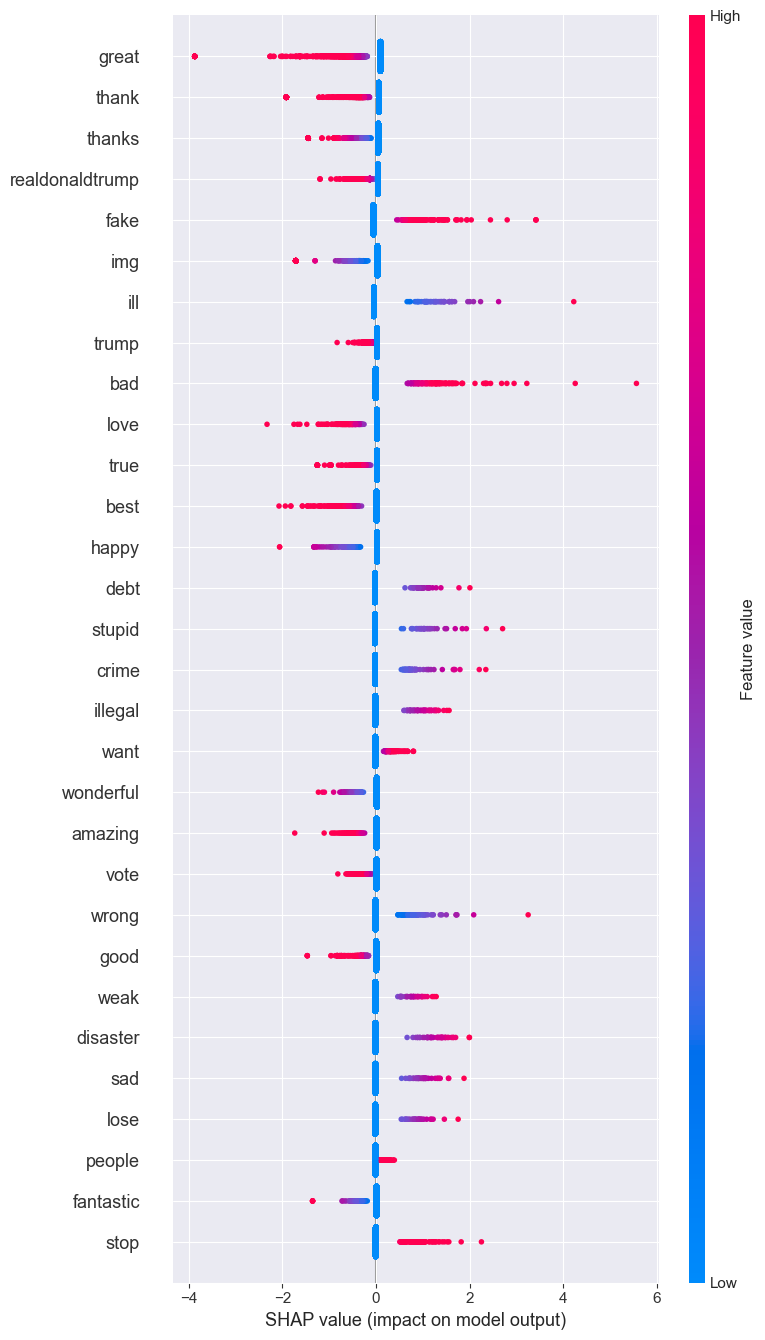

===== Klasa: neutral =====


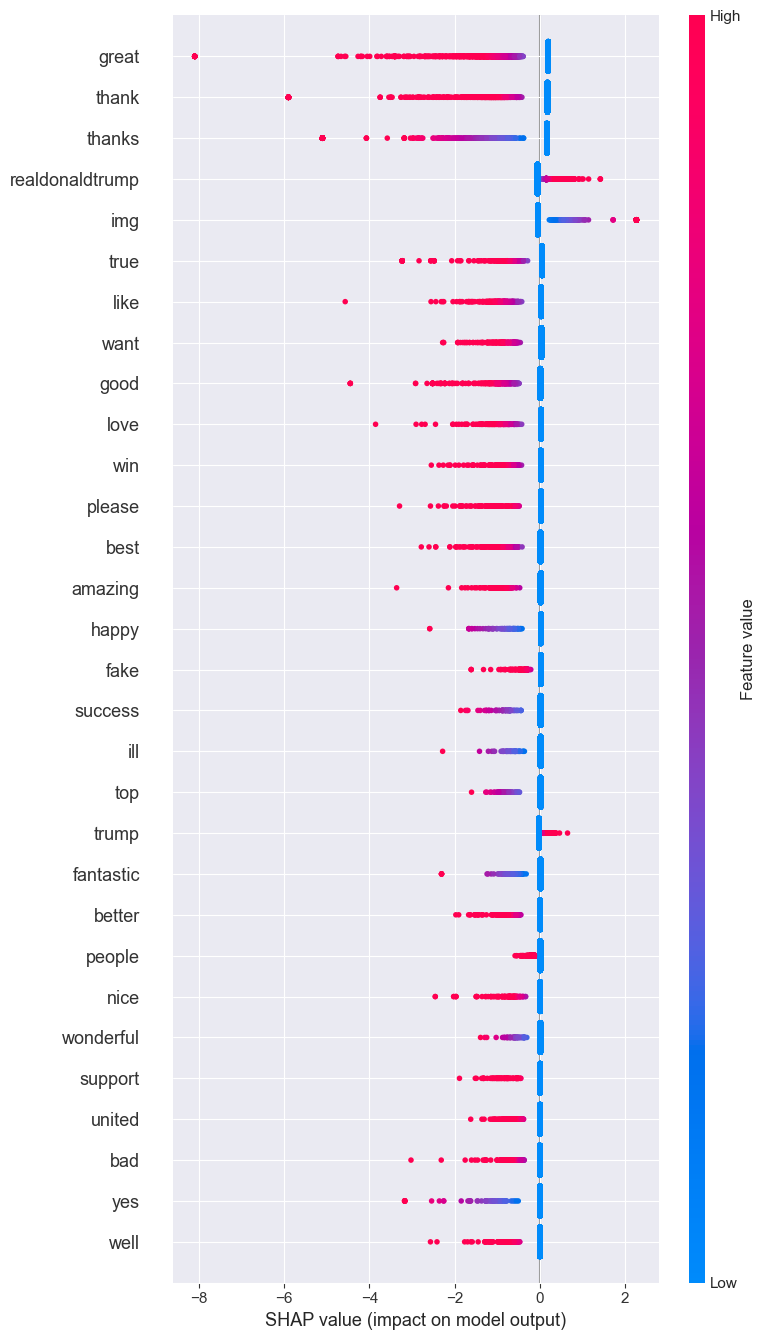

===== Klasa: positive =====


In [ ]:
# ========================================
# 4) Beeswarm plot (summary_plot) - Z KOLORAMI
# ========================================

feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
class_names = pipeline.named_steps['clf'].classes_

X_test_df = pd.DataFrame(X_test_tfidf, columns=feature_names)

for i, class_name in enumerate(class_names):
    print(f"===== Klasa: {class_name} =====")
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test_df,
        feature_names=feature_names,
        plot_type='dot',
        show=True,
        max_display=30
    )